# Simple Notebook to help visualize Energy Production / Consumption Data of a household

Julian Lee <julian.lee@microsoft.com>
Nicholas Moore <nicholas.moore@microsoft.com>

This dataset was obtained from a digital energy meter in Australia from a home in Sydney with 21 solar panels (6.6kw system) on the roof with a maximum inverter output of 5kw. 

This dataset ranges from June 2019 to July 2020.

This particular source was obtained from Endevaour Energy, proof of ownership of the NMI meter is required. 

An example of this form is as follows
[click here](https://www.endeavourenergy.com.au/CADMeterData/webengine/consumer/MeterDataForm)


### Import visualization libraries

In [ ]:
#Run this if you do not have the relevant packages

!pip install numpy pandas seaborn matplotlib

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as plticker

sns.set_style("whitegrid")

%matplotlib inline

### Read the data

In [3]:
df = pd.read_csv("data/sampleEnergy.csv")


In [4]:
df.describe()

,AccountNumber,NMI,DeviceNumber,ProfileReadValue,RegisterReadValue,BOMTEMP
count,3.148400e+04,3.148400e+04,31484.0,31484.000000,31484.0,31484.000000
mean,7.060472e+09,4.310282e+10,700373538.0,0.270712,0.0,16.382753
std,0.000000e+00,0.000000e+00,0.0,0.466867,0.0,5.384995
min,7.060472e+09,4.310282e+10,700373538.0,0.000000,0.0,3.000000
25%,7.060472e+09,4.310282e+10,700373538.0,0.000000,0.0,12.900000
50%,7.060472e+09,4.310282e+10,700373538.0,0.072000,0.0,15.600000
75%,7.060472e+09,4.310282e+10,700373538.0,0.272250,0.0,19.000000
max,7.060472e+09,4.310282e+10,700373538.0,3.253000,0.0,43.300000


In [5]:
df.head()

,AccountNumber,NMI,DeviceNumber,DeviceType,RegisterCode,RateTypeDescription,StartDate,EndDate,ProfileReadValue,RegisterReadValue,QualityFlag,BOMTEMP
0,7060472128,43102824698,700373538,COMMS4D,73538#B1,Solar,11/07/2019 0:00,11/07/2019 0:29,0.0,0,E,13.5
1,7060472128,43102824698,700373538,COMMS4D,73538#E1,Generalusage,11/07/2019 0:00,11/07/2019 0:29,0.0,0,E,13.5
2,7060472128,43102824698,700373538,COMMS4D,73538#B1,Solar,11/07/2019 0:30,11/07/2019 0:59,0.0,0,E,13.2
3,7060472128,43102824698,700373538,COMMS4D,73538#E1,Generalusage,11/07/2019 0:30,11/07/2019 0:59,0.0,0,E,13.2
4,7060472128,43102824698,700373538,COMMS4D,73538#B1,Solar,11/07/2019 1:00,11/07/2019 1:29,0.0,0,E,13.3


The dataset contains a variety of values in long-format, in 30 minute intervals; the Solar Generation, ie what was produced by the system and Generalusage, ie what was bought from the grid are reported. Do note that the variable BOMTEMP is average hourly temperature data of the day that was merge with this dataset. Methods not shown for brevity. 

### This dataset needs fixing

Unfortunately, and with most data science problems; the datasets needs a bit of reformatting. Let's use the `pandas` to reshape this dataset to illistrate what we'd like to visualize. Here, we are also featurizing the dataset; extracting additional columns such as "Hour", "Day" and "Month" from the "EndDate" column.

In [6]:
df["EndDate"] = pd.to_datetime(df["EndDate"], format="%d/%m/%Y %H:%M")
df["RateTypeDescription"] = df["RateTypeDescription"].astype('category')

df["Hour"] = df["EndDate"].dt.hour
df["Day"] = df["EndDate"].dt.day_name()
df["Month"] = df["EndDate"].dt.month_name()

df_ave_solar_by_time = df.loc[df["RateTypeDescription"] == "Solar"].groupby(['Hour','Day','Month'], as_index=False).agg({'ProfileReadValue':'mean'})
df_ave_consumption_by_time = df.loc[df["RateTypeDescription"] == "Generalusage"].groupby(['Hour','Day','Month'], as_index=False).agg({'ProfileReadValue':'mean'})

### Some Explanation

The following graph show Solar Production and Consumption from July 12 to July 16; while not very clear, it shows in the evening that solar production is 0 and night time energy consumption is very low; also note that when solar production is max (in the full sunlight); energy consumption is 0, as the house consumes the Solar-generated power first before pulling from the grid. 

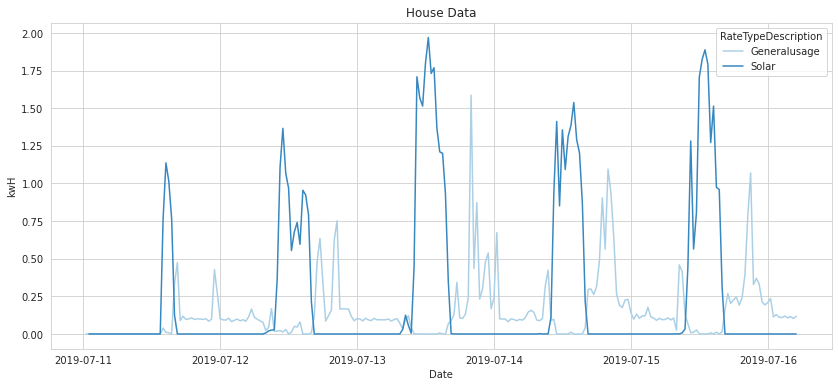

In [7]:
fig, ax = plt.subplots(figsize=(14,6))

p = sns.lineplot(data=df.iloc[1:500], x="EndDate", y="ProfileReadValue", hue="RateTypeDescription", palette="Blues")

plt.xlabel('Date')
plt.ylabel('kwH')
plt.title('House Data')

plt.show()

### But we don't really like this graph

We can do better; the visualization doesn't give us a sense on how we use our energy in the daytime / nightime and how that differs from month to month. 

Let's reshape the data to visualize this differently

In [8]:
def pivot_by_week_and_hour(df, month):
    df = df.loc[df['Month'] == month]

    df_pivot = df.reset_index()\
    .pivot("Hour", "Day", "ProfileReadValue")\
    .reindex(columns= ['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    return df_pivot

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August', 'September', 'October', 'November', 'December']

solar_by_week_and_hour_dfs = [pivot_by_week_and_hour(df_ave_solar_by_time, month) for month in months]
consumption_by_week_and_hour_dfs = [pivot_by_week_and_hour(df_ave_consumption_by_time, month) for month in months]

In [9]:
# df_ave_solar_by_time = df.loc[df["RateTypeDescription"] == "Solar"].groupby(['Hour','Day','Month'], as_index=False).agg({'ProfileReadValue':'mean'})
# df_ave_consumption_by_time = df.loc[df["RateTypeDescription"] == "Generalusage"].groupby(['Hour','Day','Month'], as_index=False).agg({'ProfileReadValue':'mean'})

### And plot some nicer heatmaps

Humans are visual - as they say, "A picture is a 1000 words" - apply very strongly in Data Science

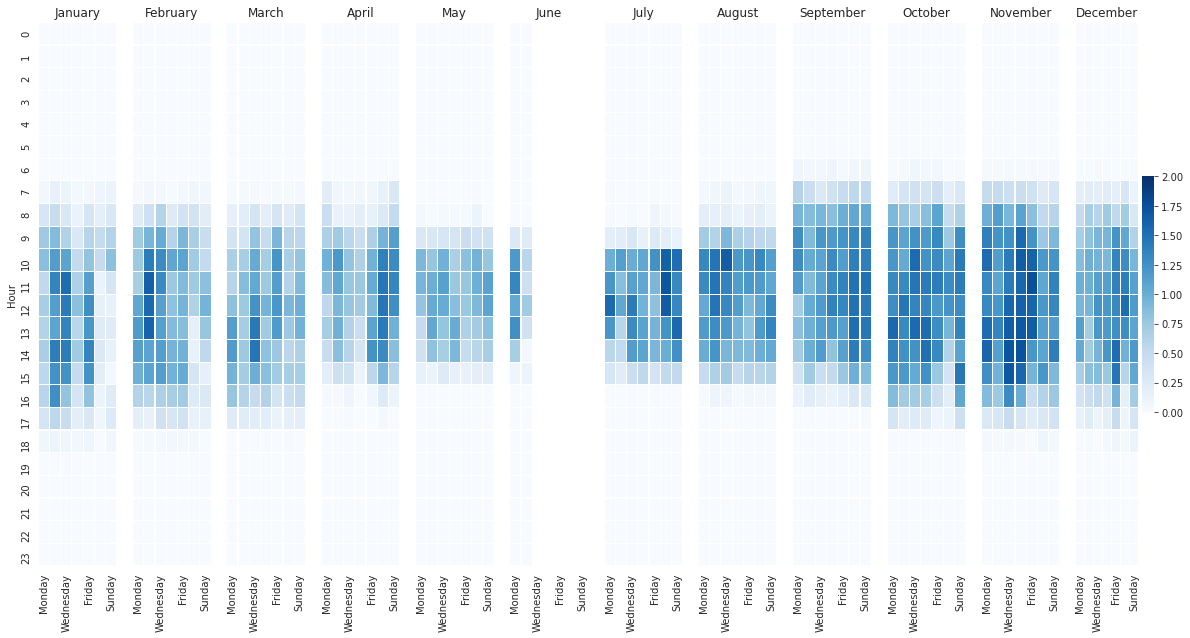

In [10]:
fig = plt.figure(figsize = (20,10))

for df_idx, solar_df in enumerate(solar_by_week_and_hour_dfs):
    chart_idx = df_idx + 1
    
    ax = fig.add_subplot(1, 12, chart_idx)
    
    include_yticklabels = chart_idx == 1
    include_cbar = chart_idx == 12 
    
    p = sns.heatmap(data=solar_df, ax=ax, cbar=include_cbar, yticklabels=include_yticklabels, cmap="Blues", linewidth=0.1, vmax=2)
    p.set_xlabel('')
    p.set_title(months[df_idx])
    if chart_idx > 1:
        p.set_ylabel('')
        
plt.show()

It's quite clear that the Summer Months (November /December) in Australia; there's more solar and in the winter months (May - July) there's less solar. What about power consumption from the grid?

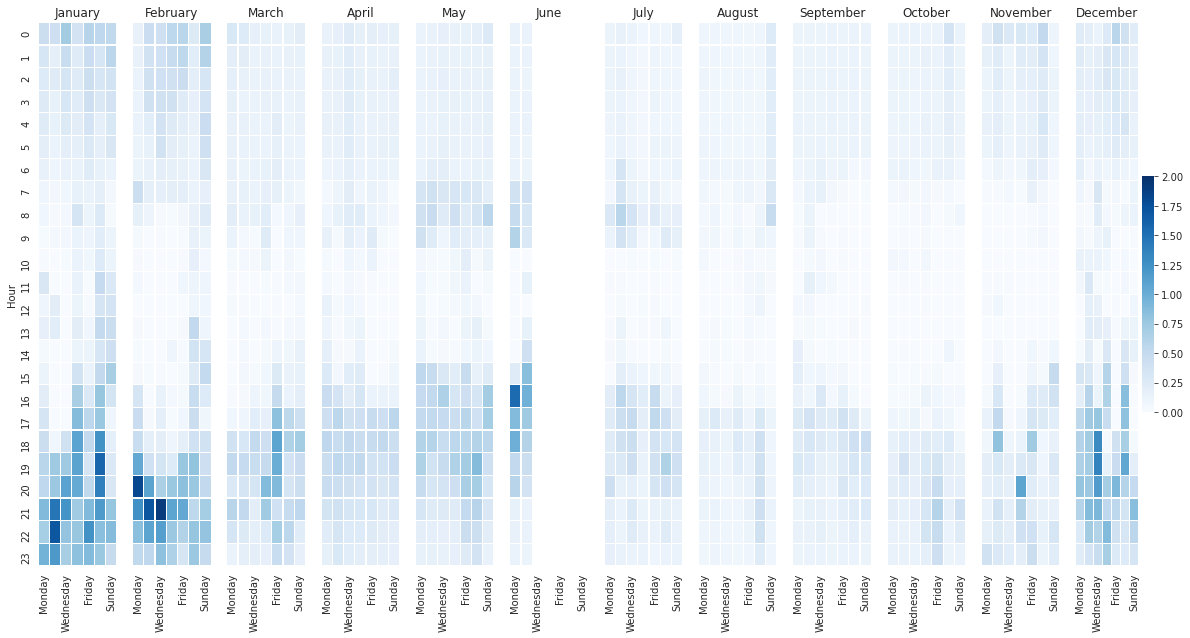

In [11]:
fig = plt.figure(figsize = (20,10))

for df_idx, consumption_df in enumerate(consumption_by_week_and_hour_dfs):
    chart_idx = df_idx + 1
    
    ax = fig.add_subplot(1, 12, chart_idx)
    
    include_yticklabels = chart_idx == 1
    include_cbar = chart_idx == 12 
    
    p = sns.heatmap(data=consumption_df, ax=ax, cbar=include_cbar, yticklabels=include_yticklabels, cmap="Blues", linewidth=0.1, vmax=2)
    p.set_xlabel('')
    p.set_title(months[df_idx])
    if chart_idx > 1:
        p.set_ylabel('')
        
plt.show()

We see a nice consistent pattern - in the Mid day when the sun is at its peak; the house does not consume much kwH of energy from the grid. The night time has different patterns from summer / winter also; there appears to be larger energy demands in the summer months (Is the AC on?) vs the winter months. 

Can you spot consumption patterns that differ from Weekday and Weekend? 

These patterns will be useful and can be teased out when we build ML models on them.